In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [3]:
# loading excel sheets, combining all sheets for two excel files
forest_file = "Bird_Monitoring_Data_FOREST.XLSX"
grassland_file = "Bird_Monitoring_Data_GRASSLAND.XLSX"
def merge_non_empty_sheets(file_path):
    xls = pd.ExcelFile(file_path)
    dfs = []

    for sheet in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet)
        if not df.empty:  # Only add non-empty sheets
            df["Source_Sheet"] = sheet  # Add sheet name for reference
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Load and merge non-empty sheets
forest_data = merge_non_empty_sheets(forest_file)
grassland_data = merge_non_empty_sheets(grassland_file)

# Display dataset heads
print("Forest Data:")
print(forest_data.head(5), "\n")
print("Grassland Data:")
print(grassland_data.head(5), "\n")

Forest Data:
  Admin_Unit_Code Sub_Unit_Code Site_Name  Plot_Name Location_Type  Year  \
0            ANTI           NaN    ANTI 1  ANTI-0036        Forest  2018   
1            ANTI           NaN    ANTI 1  ANTI-0036        Forest  2018   
2            ANTI           NaN    ANTI 1  ANTI-0036        Forest  2018   
3            ANTI           NaN    ANTI 1  ANTI-0036        Forest  2018   
4            ANTI           NaN    ANTI 1  ANTI-0036        Forest  2018   

        Date Start_Time  End_Time          Observer  ...  AOU_Code  \
0 2018-05-22   06:19:00  06:29:00  Elizabeth Oswald  ...      EATO   
1 2018-05-22   06:19:00  06:29:00  Elizabeth Oswald  ...      WBNU   
2 2018-05-22   06:19:00  06:29:00  Elizabeth Oswald  ...      RBWO   
3 2018-05-22   06:19:00  06:29:00  Elizabeth Oswald  ...      OROR   
4 2018-05-22   06:19:00  06:29:00  Elizabeth Oswald  ...      NOMO   

  PIF_Watchlist_Status Regional_Stewardship_Status Temperature   Humidity  \
0                False          

In [4]:
#data precrocessing and data cleaning
#finding null values
print("Missing values in Forest Data:\n", forest_data.isnull().sum(), "\n")
print("Missing values in Grassland Data:\n", grassland_data.isnull().sum(), "\n")

Missing values in Forest Data:
 Admin_Unit_Code                   0
Sub_Unit_Code                  7824
Site_Name                         0
Plot_Name                         0
Location_Type                     0
Year                              0
Date                              0
Start_Time                        0
End_Time                          0
Observer                          0
Visit                             0
Interval_Length                   0
ID_Method                         1
Distance                         92
Flyover_Observed                  0
Sex                            5183
Common_Name                       0
Scientific_Name                   0
AcceptedTSN                       9
NPSTaxonCode                      0
AOU_Code                          0
PIF_Watchlist_Status              0
Regional_Stewardship_Status       0
Temperature                       0
Humidity                          0
Sky                               0
Wind                            

In [5]:
# Dropping  empty column Sub_Unit_Code if it exists in both datasets
drop_cols_forest = ["Sub_Unit_Code"] if "Sub_Unit_Code" in forest_data.columns else []
drop_cols_grass = ["Sub_Unit_Code"] if "Sub_Unit_Code" in forest_data.columns else []
forest_data.drop(columns=drop_cols_forest, inplace=True, errors="ignore")
grassland_data.drop(columns=drop_cols_grass, inplace=True, errors="ignore")
forest_data.drop(columns=["Site Name"], inplace=True, errors="ignore")


In [6]:
print(forest_data.isnull().sum(), "\n")
print(grassland_data.isnull().sum(), "\n")

Admin_Unit_Code                   0
Site_Name                         0
Plot_Name                         0
Location_Type                     0
Year                              0
Date                              0
Start_Time                        0
End_Time                          0
Observer                          0
Visit                             0
Interval_Length                   0
ID_Method                         1
Distance                         92
Flyover_Observed                  0
Sex                            5183
Common_Name                       0
Scientific_Name                   0
AcceptedTSN                       9
NPSTaxonCode                      0
AOU_Code                          0
PIF_Watchlist_Status              0
Regional_Stewardship_Status       0
Temperature                       0
Humidity                          0
Sky                               0
Wind                              0
Disturbance                       0
Initial_Three_Min_Cnt       

In [7]:
# making column names of both excels same
forest_data.rename(columns={"NPSTaxonCode": "TaxonCode"}, inplace=True)
grassland_data.rename(columns={"Previously_Obs": "Previously_Observed"}, inplace=True)


In [8]:
# Convert numeric columns
forest_data["Year"] = pd.to_numeric(forest_data["Year"], errors="coerce")
grassland_data["Year"] = pd.to_numeric(grassland_data["Year"], errors="coerce")

forest_data["Visit"] = pd.to_numeric(forest_data["Visit"], errors="coerce")
grassland_data["Visit"] = pd.to_numeric(grassland_data["Visit"], errors="coerce")


In [ ]:
# Function to extract numeric value from string
def extract_distance(value):
    if pd.isna(value):
        return np.nan  # Keeping NaNs for now
    value = str(value).replace(' Meters', '').strip()  # Ensure it's a string and remove ' Meters'
    
    if '<=' in value:  # Handling values like '<=50'
        return float(value.replace('<=', '').strip())
    elif '-' in value:  # Handling ranges like '50 - 100'
        try:
            start, end = map(float, value.split('-'))  # Convert both to float
            return (start + end) / 2  # Return the average
        except ValueError:
            print(f"Skipping invalid value: {value}")  # Debugging
            return np.nan
    else:
        try:
            return float(value)  # If it's already a number
        except ValueError:
            print(f"Skipping invalid value: {value}") 
            return np.nan

# Apply function to Distance column
forest_data['Distance'] = forest_data['Distance'].apply(extract_distance).astype(float)
grassland_data['Distance'] = grassland_data['Distance'].apply(extract_distance).astype(float)

# Check if there are any NaN values before filling them
if forest_data['Distance'].isna().sum() > 0:
    print("NaN values detected in forest_data['Distance'], filling with mean...")
    forest_data['Distance'].fillna(forest_data['Distance'].mean())

if grassland_data['Distance'].isna().sum() > 0:
    print("NaN values detected in grassland_data['Distance'], filling with mean...")
    grassland_data['Distance'].fillna(grassland_data['Distance'].mean())

# Print results for debugging
print(forest_data.head(5))
print(grassland_data.head(5))



In [34]:
# Function to extract numeric value from string
def extract_interval(value):
    if pd.isna(value):
        return np.nan  # Keeping NaNs for now
    value = str(value).replace(' min', '').strip()  # Ensure it's a string and remove ' Meters'
    
    if '-' in value:  # Handling ranges like '0-2.5'
        try:
            start, end = map(float, value.split('-'))  # Convert both to float
            return (start + end) / 2  # Return the average
        except ValueError:
            print(f"Skipping invalid value: {value}")  # Debugging
            return np.nan
    else:
        try:
            return float(value)  # If it's already a number
        except ValueError:
            print(f"Skipping invalid value: {value}") 
            return np.nan

# Apply function to Interval_Length column
forest_data['Interval_Length'] = forest_data['Interval_Length'].apply(extract_interval).astype(float)
grassland_data['Interval_Length'] = grassland_data['Interval_Length'].apply(extract_interval).astype(float)
# Check if there are any NaN values before filling them and imputing with mean
if forest_data['Interval_Length'].isna().sum() > 0:
    forest_data['Interval_Length'].fillna(forest_data['Interval_Length'].mean())

if grassland_data['Interval_Length'].isna().sum() > 0:
    grassland_data['Interval_Length'].fillna(grassland_data['Interval_Length'].mean())

def encode_wind_speed(value):
    if pd.isna(value):
        return np.nan  # Handle missing values
    
    # Extract numeric values using regex
    match = re.search(r'(\d+)\s*-\s*(\d+)|<\s*(\d+)|(\d+)\s*mph', value)
    
    if match:
        if match.group(1) and match.group(2):  # If it's a range like "1-3 mph"
            return (int(match.group(1)) + int(match.group(2))) / 2  # Take the average
        elif match.group(3):  # If it's "< 1 mph"
            return int(match.group(3))  # Use the single number
        elif match.group(4):  # If it's just a single number like "5 mph"
            return int(match.group(4))  
    return np.nan  # If no match found, return NaN

# Apply this function to the 'Wind' column
forest_data['Wind'] = forest_data['Wind'].apply(encode_wind_speed)
grassland_data['Wind'] = grassland_data['Wind'].apply(encode_wind_speed)

In [10]:
fill_dict = {"Sex": "Unknown", "AcceptedTSN": "Unknown", "TaxonCode": "Unknown", "ID_Method": "Unknown"}
forest_data.fillna(fill_dict,inplace=True)
grassland_data.fillna(fill_dict,inplace=True)

In [11]:
# Remove duplicates
forest_data.drop_duplicates(inplace=True)
grassland_data.drop_duplicates(inplace=True)

In [12]:
# Recheck missing values
print("Missing values in Forest Data:\n", forest_data.isnull().sum(), "\n")
print("Missing values in Grassland Data:\n", grassland_data.isnull().sum(), "\n")

Missing values in Forest Data:
 Admin_Unit_Code                0
Site_Name                      0
Plot_Name                      0
Location_Type                  0
Year                           0
Date                           0
Start_Time                     0
End_Time                       0
Observer                       0
Visit                          0
Interval_Length                0
ID_Method                      0
Distance                       0
Flyover_Observed               0
Sex                            0
Common_Name                    0
Scientific_Name                0
AcceptedTSN                    0
TaxonCode                      0
AOU_Code                       0
PIF_Watchlist_Status           0
Regional_Stewardship_Status    0
Temperature                    0
Humidity                       0
Sky                            0
Wind                           0
Disturbance                    0
Initial_Three_Min_Cnt          0
Source_Sheet                   0
dtype: int6

In [19]:
#merging both dataframes
common_columns = list(set(forest_data.columns) & set(grassland_data.columns))

forest_data = forest_data[common_columns]
grassland_data = grassland_data[common_columns]

# Add an identifier column to distinguish ecosystem type
forest_data["Ecosystem"] = "Forest"
grassland_data["Ecosystem"] = "Grassland"

# Merge both datasets
combined_data = pd.concat([forest_data, grassland_data], ignore_index=True)

# Saving excel and csv for Power BI
combined_data.to_excel("Merged_Bird_Data.xlsx", index=False)
combined_data.to_csv("Merged_Bird_Data.csv", index=False)

In [16]:
merged_df = pd.read_excel("Merged_Bird_Data.xlsx")
print("Merged DataFrame head:\n", merged_df.head(5), "\n")

Merged DataFrame head:
           Disturbance  Temperature              Common_Name           Sex  \
0  No effect on count         19.9           Eastern Towhee  Undetermined   
1  No effect on count         19.9  White-breasted Nuthatch       Unknown   
2  No effect on count         19.9   Red-bellied Woodpecker       Unknown   
3  No effect on count         19.9           Orchard Oriole       Unknown   
4  No effect on count         19.9     Northern Mockingbird       Unknown   

        Date  Initial_Three_Min_Cnt TaxonCode  PIF_Watchlist_Status  Year  \
0 2018-05-22                   True     83803                 False  2018   
1 2018-05-22                   True     90935                 False  2018   
2 2018-05-22                  False     84865                 False  2018   
3 2018-05-22                  False     93634                 False  2018   
4 2018-05-22                  False     88394                 False  2018   

           Scientific_Name  ... Flyover_Observed D

In [35]:
#EDA
print(merged_df.describe(), "\n")

        Temperature                           Date     Year  Interval_Length  \
count  15372.000000                          15372  15372.0     15372.000000   
mean      22.493826  2018-06-13 17:45:11.943794176   2018.0         3.554027   
min       11.000000            2018-05-07 00:00:00   2018.0         1.250000   
25%       19.700001            2018-05-24 00:00:00   2018.0         1.250000   
50%       22.200001            2018-06-14 00:00:00   2018.0         1.250000   
75%       25.000000            2018-07-03 00:00:00   2018.0         6.250000   
max       37.299999            2018-07-19 00:00:00   2018.0         8.750000   
std        4.193138                            NaN      0.0         2.733362   

               Wind      Distance      Humidity         Visit  
count  15372.000000  15372.000000  15372.000000  15372.000000  
mean       2.635799     63.273546     74.159335      1.690997  
min        1.000000     50.000000      7.300000      1.000000  
25%        1.000000    

<Figure size 1200x800 with 0 Axes>

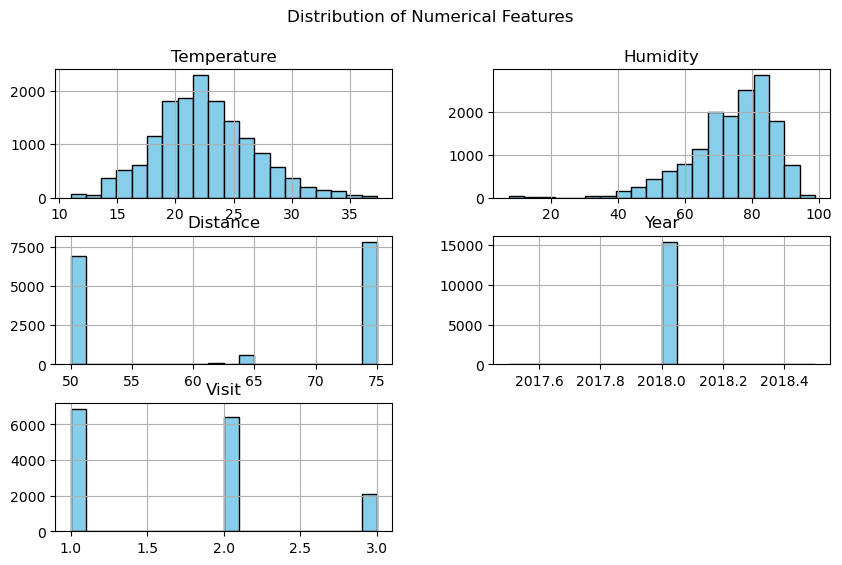

In [37]:
num_features = ['Temperature', 'Humidity', 'Distance', 'Interval_Length', 'Wind', 'Year', 'Visit']

plt.figure(figsize=(12, 8))
combined_data[num_features].hist(figsize=(10, 6), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

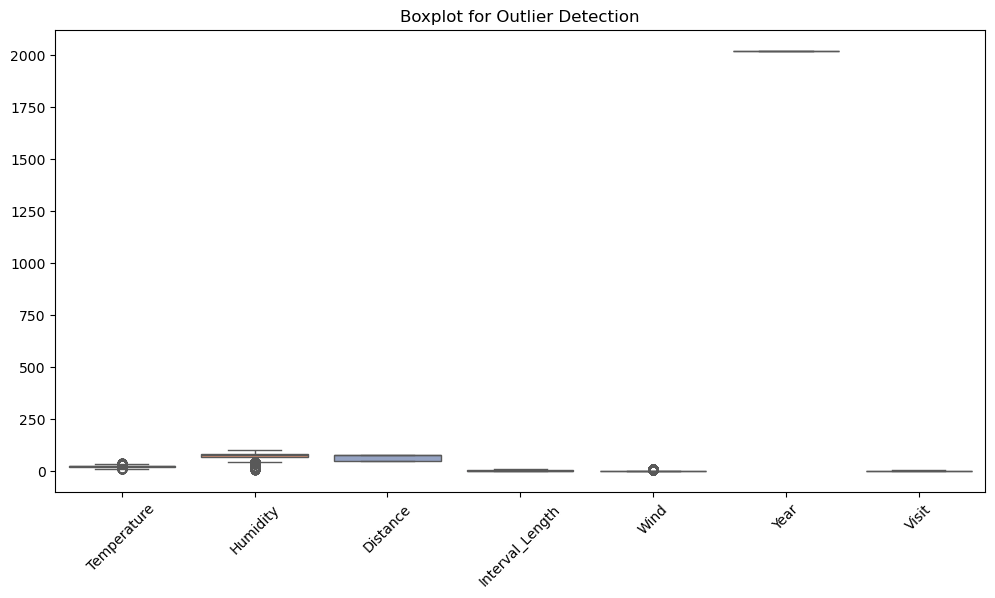

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[num_features], palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()


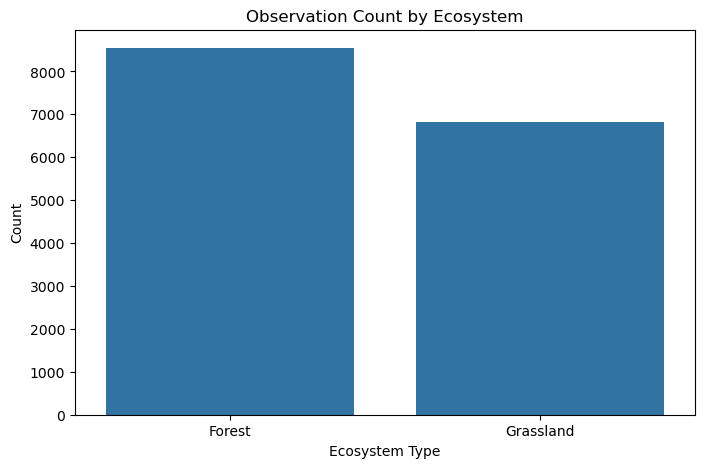

In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='Ecosystem')
plt.title("Observation Count by Ecosystem")
plt.xlabel("Ecosystem Type")
plt.ylabel("Count")
plt.show()


C:\Users\Chia\AppData\Local\Temp\ipykernel_3684\2168182543.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_species.index, y=top_species.values, palette="magma")


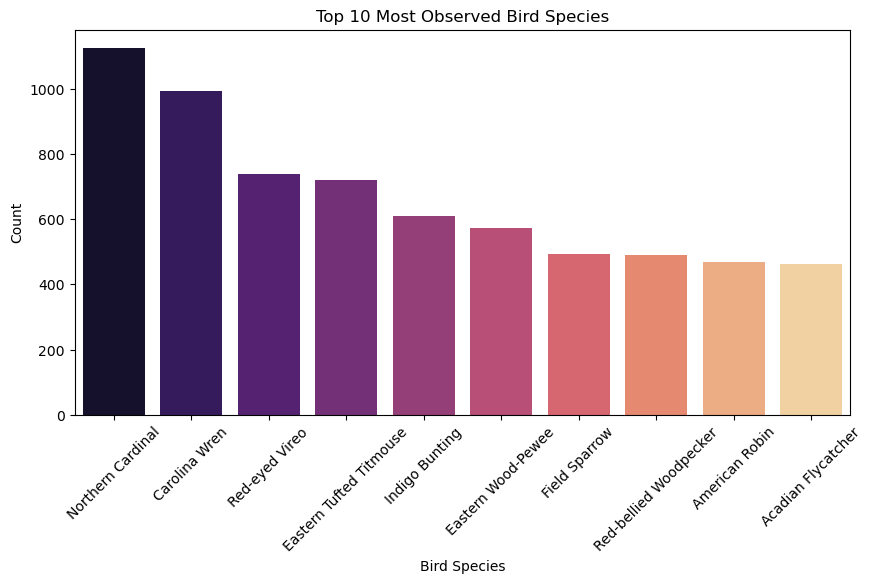

In [31]:
plt.figure(figsize=(10, 5))
top_species = merged_df['Common_Name'].value_counts().head(10)
sns.barplot(x=top_species.index, y=top_species.values, palette="magma")
plt.xticks(rotation=45)
plt.title("Top 10 Most Observed Bird Species")
plt.xlabel("Bird Species")
plt.ylabel("Count")
plt.show()


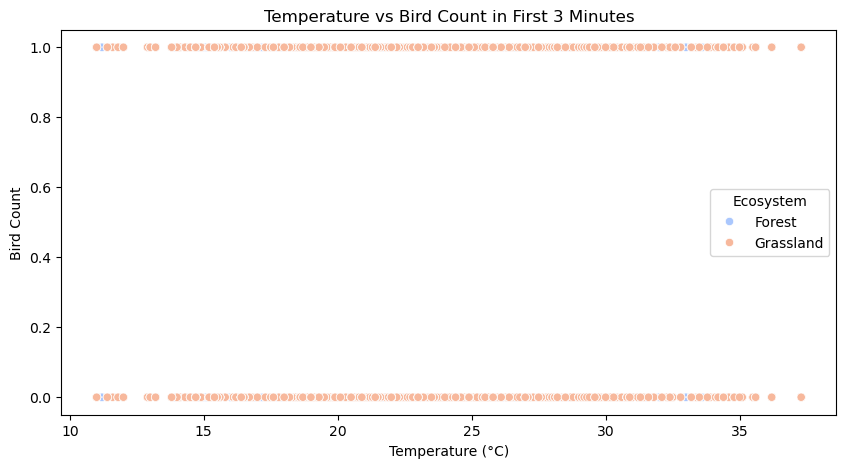

In [39]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=combined_data, x='Temperature', y='Initial_Three_Min_Cnt', hue='Ecosystem', palette="coolwarm")
plt.title("Temperature vs Bird Count in First 3 Minutes")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bird Count")
plt.show()

